# Stress Classifier
## Overview
1. [Select Database](#1-select-database)
2. [Import Libraries and Load Useful Utilities](#2-import-libraries-and-load-useful-utilities)
3. [Data Extraction](#3-data-extraction): Downloads and sorts through databases.
4. [Pre-processing](#4-pre-processing): filtering and signal cleaning.
5. [Feature Extraction](#5-feature-extraction): R-R peaks, PQRST peaks, EDR, in addition to mean, kurtosis etc.
6. [Feature Selection](#6-feature-selection): Visualise labelled feature distribution, select desired labels etc.
7. [Linear Classification](#7-linear-classification): Linear classification including Random Forests, LDA etc.

## 1. Select Database
Select between:
* [Spider-Fearful ECG](https://doi.org/10.1371/journal.pone.0231517) 
* BrainPatch ECG

In [1]:
DATABASE = 'Spider'

## 2. Import Libraries and Load Useful Utilities
Please run `pip install -r requirements.txt` first

In [2]:
# Import necessary modules
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
import os
import sys
import subprocess
import warnings
import seaborn as sns
import math
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import product
from typing import List

In [3]:
# Useful Utilities
class Utilities():
    def __init__(self):    
        pass

    def progress_bar(current_message, current, total, bar_length=20):
        fraction = current / total
        arrow = int(fraction * bar_length - 1) * '-' + '>'
        padding = int(bar_length - len(arrow)) * ' '
        ending = '\n' if current == total else '\r'
        print(f'{current_message}: [{arrow}{padding}] {int(fraction*100)}%', end=ending)


    def check_csv_exists(folder_path, index):
        # read the CSV file into a dataframe and append to the list
        filename = os.path.join(folder_path, f'df_{index}.csv')
        try:
            df = pd.read_csv(filename)
        except FileNotFoundError:
            return False
        return filename


    def load_dataframe(filename):
        # read the CSV file into a dataframe and append to the list
        df = pd.read_csv(filename)
        return df
    

    def save_dataframe_list(list_of_dfs:List[pd.DataFrame], folder_path:str, file_name:str):
        # create directoy if necessary
        os.makedirs(folder_path, exist_ok=True) 
        for i, df in enumerate(list_of_dfs):
            file_path = f"{folder_path}/{file_name}_{i}.csv"
            df.to_csv(file_path, index=False)


    def save_dataframe(df:pd.DataFrame, folder_path:str, file_name:str):
        # create directoy if necessary
        os.makedirs(folder_path, exist_ok=True) 
        df.to_csv(f'{folder_path}/{file_name}.csv', index=False)

In [4]:
# For bigger plots
plt.rcParams['figure.figsize'] = [10, 6]  
plt.rcParams['font.size'] = 14

## 3. Data Extraction
* Downloads data, normalizes timeframe, attaches labels, and saves sorted data.

In [5]:
# This class handles downloading and sorting the Spider database.
# Method from this paper https://doi.org/10.1371/journal.pone.0231517
class SpiderDataExtraction():
    def __init__(self, directory):
        self.directory = directory
        self.sampling_frequency = 100
        self.sorted_ECG = pd.DataFrame(columns=['Timestamp', 'ECG', 'Stress Level'])

    
    # Downloads and extracts database 
    def download_data(self):
        if sys.platform == 'linux':
            url = 'https://physionet.org/files/ecg-spider-clip/1.0.0/'
            print("Downloading database...this may take a while")
            os.makedirs(self.directory, exist_ok=True)
            cmd = f"wget -r -N -c -np -P {self.directory} {url}"
            subprocess.run(cmd)
        else:
            sys.exit("Unable to download database. If you are running Windows/Mac please download manually via https://physionet.org/content/ecg-spider-clip/1.0.0/")
    

    # sorts data from each participant, labelling each ECG recording and appends to one dataframe.
    # Following the SB approach in the study.
    def sort_data(self):       
        directory = self.directory + '/physionet.org/files/ecg-spider-clip/1.0.0/'
        
        # Exclude VP70 because of noise
        sub_directories = ['VP02', 'VP03','VP05','VP06','VP08','VP09','VP11','VP12','VP14','VP15','VP17','VP18','VP20','VP23','VP24','VP26','VP27',
                'VP29','VP30','VP32','VP33','VP35','VP36','VP38','VP39','VP41','VP42','VP44','VP45','VP47','VP48','VP50','VP51','VP53',
                'VP54','VP56','VP57','VP59','VP61','VP62','VP63','VP64','VP65','VP66','VP68','VP69','VP71','VP72','VP73','VP74',
                'VP75','VP76','VP77','VP78','VP79','VP80']
        
        # Path to Ratings file for all particpants
        subjective_ratings_file = f'{self.directory}/Subjective Ratings.txt'

        # Read in the subject ratings file (ignore arousal markers, interested in angst)
        ratings_df = (
            pd.read_csv(subjective_ratings_file, sep='\t', names=['Subject','Group','Session', '4', '8', '12', '16', 'NA1', 'NA2', 'NA3', 'NA4'], encoding='UTF-16')
            .drop(columns=['NA1', 'NA2', 'NA3', 'NA4'])
            .iloc[1:]
            .reset_index(drop=True)
            .astype(int)
        )

        for index, sub_directory in enumerate(sub_directories):
            Utilities.progress_bar('Sorting database', index, len(sub_directories)-1)

            # set participant data paths
            ECG_file = f'{directory}{sub_directory}/BitalinoECG.txt'
            triggers_file = f'{directory}{sub_directory}/Triggers.txt'

            # Get participant number
            participant_no = int(sub_directory[2:])

            # read in particpant ECG raw data file and reorder to get columns Timestamp, ECG 
            raw_df = pd.read_csv(ECG_file, sep='\t', names = ['ECG','Timestamp','NA'])
            raw_df = raw_df.drop(columns=['NA'])
            raw_df = raw_df[['Timestamp', 'ECG']]
            
            # Read in participant trigger file
            triggers_df = pd.read_csv(triggers_file, sep='\t', names = ['Clip','On','Off'])

            # Determine stress levels by correspoding the raw ecg data with the triggers file and the Subjective Ratings file.
            # Iterate through the 16 stress clips (first clip is a demo):
            for i in range(1, 17):
                # Determine row in ratings file
                row = ratings_df.loc[ratings_df['Subject'] == participant_no].index[0]

                # find stress for the clip in the ratings file
                stress_level = ratings_df.iloc[row]['4'] if i <= 4 else ratings_df.iloc[row]['8'] if i <= 8 else ratings_df.iloc[row]['12'] if i <= 12 else ratings_df.iloc[row]['16']

                # convert stress level to Low, Medium or High (1-3)
                stress_level = 2 if (stress_level <= 2) else 3

                # Get 60 second slice of ECG data for that clip
                clip_start_time = triggers_df.iloc[i]['On']
                start_index = raw_df.index[raw_df['Timestamp']>clip_start_time].tolist()[0]
                clip_df = raw_df.iloc[start_index:start_index + (self.sampling_frequency * 60)].copy(deep=False)
                clip_df['Stress Level'] = stress_level
                self.sorted_ECG = pd.concat([self.sorted_ECG, clip_df], axis=0, ignore_index=True)

            # Add the last 3 minute resting phase (stress level Low) to the data
            rest_start_time = triggers_df.iloc[-1]['On']
            start_index = (raw_df['Timestamp'] > rest_start_time).idxmin() + (self.sampling_frequency * 120)
            rest_df = raw_df.iloc[start_index: start_index + (self.sampling_frequency * 180)].copy(deep=False)
            rest_df.loc[:, 'Stress Level'] = 1
            self.sorted_ECG = pd.concat([self.sorted_ECG, rest_df], axis=0, ignore_index=True)



In [6]:
if DATABASE == 'Spider':
    sde = SpiderDataExtraction('Data/Spider')
    # sde.download_data()
    sde.sort_data()
    Utilities.save_dataframe(sde.sorted_ECG, 'Data/Spider/Dataframes', 'Sorted')

Sorting database: [------------------->] 100%


## 4. Pre-Processing
* Interpolates data to sample rate using timestamps 
* Semgents data using rolling window with overlap
* Cleans data using Neurokit's 5th Order Butterworth filter.

In [7]:
# Define PreProcessing Class:
# Segments data using rolling window 
# Cleans data using Neurokit2
# Documentation can be found here: https://neuropsychology.github.io/NeuroKit/functions/ecg.html       
class PreProcessing():
    def __init__(self, sorted_ECG:pd.DataFrame, sampling_frequency:int):
        self.sorted_ECG = sorted_ECG
        self.sampling_frequency = sampling_frequency
        self.preprocessed_ECG = pd.DataFrame(columns=['Timestamp', 'ECG', 'Stress Level'])


    # interpolates data to achieve sampling rate
    def interpolate(self):
        # convert timestamp column to a NumPy array
        timestamps = self.sorted_ECG['Timestamp'].to_numpy()

        # calculate the time difference between each pair of adjacent timestamps
        time_diff = np.diff(timestamps)

        # calculate the average sampling rate of the data
        sampling_frequency = 1 / np.mean(time_diff)

        print(f"Average sampling rate: {sampling_frequency}")

        # interpolate the data to obtain 100Hz sampling rate
        self.sorted_ECG['Timestamp'] = np.arange(timestamps[0], timestamps[-1], 1 / self.sampling_frequency)
        self.sorted_ECG['ECG'] = np.interp(self.sorted_ECG['Timestamp'], timestamps, self.sorted_ECG['ECG'])
        

    # segments data with overlap using rolling window
    def segment(self, window_length_s:int, overlap:float):
        # convert window_length in seconds to samples
        self.window_samples = window_length_s * self.sampling_frequency
        # Calculate the step_size as the fraction of the total window samples
        step_size = int(self.window_samples * (1-overlap)) 

        # Initialize starting variables
        current_index = 0
        current_stressed = self.sorted_ECG['Stress Level'][current_index]

        # faster to concatenate at the end 
        preprocessed_ECG_list = []
        
        # Loop through the entire dataframe
        while current_index < len(self.sorted_ECG['ECG']):  
            Utilities.progress_bar('Segmenting data', current_index, len(self.sorted_ECG))
            # calculate end index in window and exit if out of bounds          
            end_index = current_index + self.window_samples
            if (end_index > len(self.sorted_ECG['ECG'])):
                break
            
            # Check if the window overlaps a different label
            end_stressed = self.sorted_ECG['Stress Level'][end_index]

            # If the next window has a different label, skip to next start of next label
            if end_stressed != current_stressed:
                while (current_stressed == self.sorted_ECG['Stress Level'][current_index]):
                    current_index += 1
                current_stressed = end_stressed

            # otherwise, add segment to list of pre-processed ECG
            else:
                # append segment to dataframe
                preprocessed_ECG_list.append(self.sorted_ECG.iloc[current_index:current_index + self.window_samples].astype('Float64'))

                # Shift the window
                current_index += step_size
        
        self.preprocessed_ECG = pd.concat(preprocessed_ECG_list, axis=0, ignore_index=True).astype('Float64')
        Utilities.progress_bar('Segmenting data', current_index, current_index)

    def clean(self):
        # Clean each sample in the stressed and not stressed data (overwrites original data)
        # using method 'neurokit' (0.5 Hz high-pass butterworth filter (order = 5), followed by powerline filtering) but can be changed to other cleaning methods
        print("Cleaning data...")
        self.preprocessed_ECG['ECG'] = pd.Series(nk.ecg_clean(self.preprocessed_ECG['ECG'], self.sampling_frequency, method='neurokit')).astype('Float64')

In [8]:
pp = PreProcessing(sde.sorted_ECG, sde.sampling_frequency)

# Timestamps are not valid for Spider database, so should not interpolate.
if DATABASE != 'Spider':
    pp.interpolate()

window_length_s = 10
overlap = 0.1
pp.segment(window_length_s, overlap)
pp.clean()
Utilities.save_dataframe(pp.preprocessed_ECG, 'Data/Spider/Dataframes', 'Preprocessed')

Segmenting data: [------------------->] 100%
Cleaning data...


## 5. Feature Extraction
* Extracts features such as HRV time, frequency and non-linear domain, EDR etc.

In [9]:
# Main class that extracts features from a dictionary of sorted dataframes and stores to csv
class FeatureExtraction():
    # takes in cleaned ECG data
    def __init__(self, preprocessed_ECG:pd.DataFrame, window_samples:int, sampling_frequency:int):
        self.preprocessed_ECG = preprocessed_ECG
        self.window_samples = window_samples
        self.sampling_frequency = sampling_frequency
        self.feature_extracted_ECG = pd.DataFrame()


    # Extracts features from ECG using neurokit.
    def get_neurokit_features(self, EDR:bool=False, show_plot:bool=False):
        index = 0
        while index < len(self.preprocessed_ECG['ECG']):
            Utilities.progress_bar('Extracting Neurokit Features', index, len(self.preprocessed_ECG['ECG']))

            # get segment ECG and stress level from dataframe 
            segment = self.preprocessed_ECG.iloc[index:index + self.window_samples]['ECG']
            stress_level = self.preprocessed_ECG.iloc[index]['Stress Level']
            features = pd.DataFrame({'Stress Level': [stress_level]})
            
            index += self.window_samples

            # only show plot once
            if index!=0:
                self.show_plot = False 

            # extract R-R peaks
            np.seterr(divide="ignore", invalid="ignore")
            r_peaks_df = nk.ecg_peaks(segment, sampling_rate=self.sampling_frequency, correct_artifacts=True)[0]
            # skip segment if insufficient peaks are detected (otherwise will cause NK error)
            if int(r_peaks_df[r_peaks_df == 1].sum().iloc[0]) < 4:
                continue

            # Extract HRV features from R-R peaks, see https://neuropsychology.github.io/NeuroKit/functions/hrv.html 
            # compute HRV - time, frequency and nonlinear indices.
            warnings.filterwarnings('ignore') # temporarily supress warnings
            HRV_time = nk.hrv_time(r_peaks_df, sampling_rate=self.sampling_frequency, show=self.show_plot)
            HRV_frequency = nk.hrv_frequency(r_peaks_df, sampling_rate=self.sampling_frequency, show=self.show_plot)
            warnings.filterwarnings('default')

            # compute Shannon Entropy (SE) using signal symbolization and discretization
            # see https://neuropsychology.github.io/NeuroKit/functions/complexity.html#entropy-shannon 
            SE = nk.entropy_shannon(segment, symbolize='A')[0]
            HRV_SE = pd.DataFrame([SE], columns=['HRV_SE'])
            # concat to dataframe
            features = pd.concat([features, HRV_time, HRV_frequency, HRV_SE], axis=1)
            
            if EDR:
                # Get ECG Derived Respiration (EDR) and add to the data
                warnings.filterwarnings('ignore') # temporarily supress warnings
                ecg_rate = nk.signal_rate(r_peaks_df, sampling_rate=self.sampling_frequency, desired_length=len(r_peaks_df))
                warnings.filterwarnings('default')
                EDR_sample = nk.ecg_rsp(ecg_rate, sampling_rate=self.sampling_frequency)
                if self.show_plot:
                    nk.signalplot(segment)
                    nk.signal_plot(EDR_sample)
                EDR_Distance = pd.DataFrame(nk.signal_findpeaks(EDR_sample)["Distance"], columns=['EDR_Distance'])
                # concat to dataframe
                features = pd.concat([features, EDR_Distance], axis=1)

            # concat features to main dataframe
            self.feature_extracted_ECG = pd.concat([self.feature_extracted_ECG, features], axis=0, ignore_index=True)
        Utilities.progress_bar('Extracting Neurokit Features', index, index)

                


In [10]:
fe = FeatureExtraction(pp.preprocessed_ECG, pp.window_samples, pp.sampling_frequency)
fe.get_neurokit_features(EDR=False, show_plot=True)
Utilities.save_dataframe(fe.feature_extracted_ECG, 'Data/Spider/Dataframes', 'Feature Extracted')

Extracting Neurokit Features: [------------------->] 100%


## 6. Feature Selection:
* Select desired features, sanity check the values, and save them to Features directory
* Visualise most feature and cross-feature distribution 

In [11]:
# Each feature will be an object of FEParameter
class FEParameter:
    def __init__(self, name:str, min:float=0.0, max:float=9999):
        self.name = name
        self.min = min
        self.max = max

In [12]:
# Define FeatureSelection class that is used to visualise and select data
class FeatureSelection():
    def __init__(self, feature_extracted_ECG):
        self.feature_extracted_ECG = feature_extracted_ECG


    # desired_features is a list of FEParameter objects  
    def select(self, desired_features:List[FEParameter]):
        self.selected_features_ECG = self.feature_extracted_ECG[['Stress Level']]
        
        for feature in desired_features:
            out_of_range_count = 0
            # Sanity check: check if feature exists
            if feature.name in self.feature_extracted_ECG.columns:
                # Set value to NaN if it falls outside min and max values.
                for i, value in enumerate(self.feature_extracted_ECG[feature.name]):
                    if (value < feature.min) or (value > feature.max):
                        out_of_range_count += 1
                        self.feature_extracted_ECG.loc[i, feature.name] = np.nan
                # Add column to new selected features
                pd.options.mode.chained_assignment = None
                self.selected_features_ECG[feature.name] = self.feature_extracted_ECG[[feature.name]].copy()
                pd.options.mode.chained_assignment = 'warn'
            else:
                print(f'Error: No such feature "{feature}" in extracted features')
            if out_of_range_count != 0:
                print(f'Feature: {feature.name} is out of range {out_of_range_count}/{len(self.feature_extracted_ECG[feature.name])} segments')

        
    # impute missing values in dataset with mean values of column
    def impute(self):
        pd.options.mode.chained_assignment = None
        self.selected_features_ECG.replace([np.inf, -np.inf], np.nan, inplace=True)
        pd.options.mode.chained_assignment = 'warn'
        imp = SimpleImputer(strategy='mean')
        imp.fit(self.selected_features_ECG)
        self.selected_features_ECG = pd.DataFrame(imp.transform(self.selected_features_ECG), columns=self.selected_features_ECG.columns)


    def visualise(self, plot_type='pairplot'):
        print("Generating plot...")
        if plot_type == 'pairplot':         
            sns.pairplot(data = self.selected_features_ECG, hue='Stress Level', palette=['green', 'yellow', 'red'])
        elif plot_type == 'kdeplot':
            # Create a figure with subplots for each feature
            subplot_size = math.ceil(math.sqrt(len(self.selected_features_ECG.columns)))
            fig = plt.figure(figsize=(20, 8*subplot_size))

            # Loop through each feature and add it to a subplot
            for i, feature in enumerate(self.selected_features_ECG):
                fig.add_subplot(subplot_size, subplot_size, i+1)
                sns.kdeplot(x=feature, data=self.selected_features_ECG, hue='Stress Level', common_norm=False, warn_singular=False, palette=['green', 'yellow', 'red'])
            plt.show()
        else:
            print("Plot type not recognised. Please choose between pairplot, kdeplot")

In [13]:
# Desired Features to be selected from Feature Extracted ECG.
# See Neurokit2 HRV for more information - https://neuropsychology.github.io/NeuroKit/functions/hrv.html

# Minimum and maximum expected HR (beats per min)
min_HR = 30
max_HR = 200

# MinNN: The minimum of the RR intervals (Parent, 2019; Subramaniam, 2022).
HRV_MinNN = FEParameter('HRV_MinNN', min=60000.0/max_HR, max=60000.0/min_HR)
# MaxNN: The maximum of the RR intervals (Parent, 2019; Subramaniam, 2022).
HRV_MaxNN = FEParameter('HRV_MaxNN', min=60000.0/max_HR, max=60000.0/min_HR)
# MeanNN: The mean of the RR intervals.
HRV_MeanNN = FEParameter('HRV_MeanNN', min=60000.0/max_HR, max=60000.0/min_HR)

# SDNN: The standard deviation of the RR intervals.
# See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/ for chosen max value.
HRV_SDNN = FEParameter('HRV_SDNN', max=200)
# RMSSD: The square root of the mean of the squared successive differences between adjacent RR intervals. 
# # It is equivalent (although on another scale) to SD1, and therefore it is redundant to report correlations with both (Ciccone, 2017).
# See https://help.welltory.com/en/articles/4413231-what-normal-ranges-and-measurement-standards-we-use-to-interpret-your-heart-rate-variability for chosen max value.
HRV_RMSSD = FEParameter('HRV_RMSSD', max=107)
# The root mean square of successive differences (RMSSD) divided by the mean of the RR intervals (MeanNN).
CVSD = FEParameter('HRV_CVSD')
# Shannon Entropy
HRV_SE = FEParameter('HRV_SE')

# pNN20: The proportion of RR intervals greater than 20ms, out of the total number of RR intervals.
HRV_pNN20 = FEParameter('HRV_pNN20')
# pNN50: The proportion of RR intervals greater than 50ms, out of the total number of RR intervals.
HRV_pNN50 = FEParameter('HRV_pNN50')
# A geometrical parameter of the HRV, or more specifically, the baseline width of the RR intervals distribution 
# TINN: obtained by triangular interpolation, where the error of least squares determines the triangle. 
# It is an approximation of the RR interval distribution.
HRV_TINN = FEParameter('HRV_TINN')
# HTI: The HRV triangular index, measuring the total number of RR intervals divided by the height of the RR intervals histogram.
HRV_HTI = FEParameter('HRV_HTI')

# VLF: The spectral power (W/Hz) of very low frequencies (.0033 to .04 Hz).
HRV_VLF = FEParameter('HRV_VLF', min=0.0, max=9) # hidden due to use of 0.5 Hz high-pass butterworth filter
# LF: The spectral power (W/Hz) of low frequencies (.04 to .15 Hz).
HRV_LF = FEParameter('HRV_LF', max=1.00)
# HF: The spectral power (W/Hz) of high frequencies (.15 to .4 Hz).
HRV_HF = FEParameter('HRV_HF', max=1.00)
# LFHF: The ratio obtained by dividing the low frequency power by the high frequency power.
HRV_LFHF = FEParameter('HRV_LFHF', max=1.00)

Feature: HRV_SDNN is out of range 3/6982 segments
Feature: HRV_RMSSD is out of range 187/6982 segments
Generating plot...


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

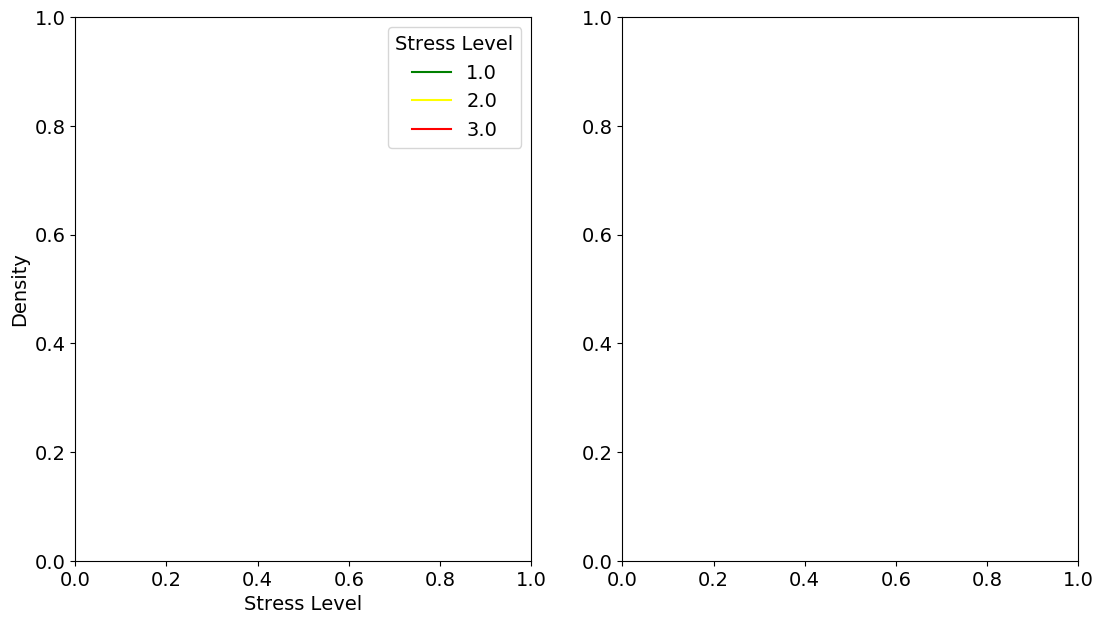

In [14]:
fs = FeatureSelection(fe.feature_extracted_ECG)
# desired features for classification
selected_features = [HRV_MinNN, HRV_MaxNN, HRV_MeanNN, HRV_SDNN, HRV_RMSSD, HRV_SE, HRV_pNN20, HRV_pNN50]
fs.select(selected_features)
fs.impute()
fs.visualise(plot_type='kdeplot')
fs.visualise(plot_type='pairplot')
Utilities.save_dataframe(fs.selected_features_ECG, 'Data/Spider/Dataframes', 'Feature Selected')

## 7. Linear Classification
* Prepares data by randomly splitting data into train, test and validation data
* Option for Linear Discriminant Analysis (LDA) for dimension reduction
* Implements the following classification models, with methods for tuning: LDA, Random Forests

In [ ]:
# Utilities for preparing and evaluating classification
class ML_Utilities():
    def __init__(self):
        pass


    # randomizes, standardizes, and splits into test and training data.
    def prepare(selected_features_ECG:pd.DataFrame, train_split:float, validation_split:float, LDA_dimension_reduction:bool=False):       
        label = selected_features_ECG['Stress Level']
        features = selected_features_ECG.loc[:, selected_features_ECG.columns != 'Stress Level']

        # split into test, training and validation data (hold-out validation)
        X_train, X_test, y_train, y_test = train_test_split(features, label, train_size=train_split, test_size=1-train_split, random_state=15)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 1-validation_split, test_size=validation_split, random_state=15)
        
        # scale 
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        # LDA for dimension reduction creates new train and test data
        if LDA_dimension_reduction:
            lda = LinearDiscriminantAnalysis()
            X_train = lda.fit_transform(X_train, y_train)
            X_test = lda.transform(X_test)
            X_valid = lda.transform(X_valid)

        return X_test, y_test, X_train, y_train, X_valid, y_valid


    def plot_confustion_matrix(y_test, y_pred):
        # Confusion Matrix
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Negative', 'Positive'])

In [ ]:
# Define LinearML method, which implements different linear classification methods
class Linear_ML():
    def __init__(self, X_train, y_train, X_test, y_test, X_valid, y_valid):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_valid = X_valid
        self.y_valid = y_valid


    # LDA classification
    def LDA_classifier(self):
        clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.5).fit(self.X_train, self.y_train)
        clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(self.X_train, self.y_train)

        clf1_score = clf1.score(self.X_test, self.y_test)
        clf2_score = clf2.score(self.X_test, self.y_test)

        print(f'Score for CLF1: {clf1_score}')
        print(f'Score for CLF2: {clf2_score}')
        

    # Tuning Random Forest
    def rf_tuner(self):
        n_estimators = 100
        max_features = [1, 'sqrt', 'log2']
        max_depths = [None, 2, 3, 4, 5]
        for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
            rf = RandomForestClassifier(n_estimators=n_estimators, 
                                        criterion='entropy', 
                                        max_features=f, 
                                        max_depth=d, 
                                        n_jobs=-1,
                                        random_state=1337)
            rf.fit(self.X_train, self.y_train)
            self.y_pred = rf.predict(X=self.X_test)
            print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(self.y_test,self.y_pred)))
            ML_Utilities.plot_confustion_matrix(self.y_test, self.y_pred)


    # Post-tuned Random Forests Classifier
    def rf_classifier(self):
        # source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
        rf.fit(self.X_train, self.y_train)
        self.y_pred = rf.predict(X=self.X_test)

        # Accuracy on Test
        print("Training Accuracy is: ", rf.score(self.X_train, self.y_train))
        # Accuracy on Train
        print("Testing Accuracy is: ", rf.score(self.X_test, self.y_test))

        self.plot_confustion_matrix()

    
        # main method to conduct LDA
    def model(self, classification_type):
        classification_types = {
            "LDA": self.LDA_classifier,
            "RF": self.rf_classifier
        }
        classification_types.get(classification_type, lambda: print("Invalid model. Please enter LDA, RF"))()        


In [ ]:
selected_features_ECG = Utilities.load_dataframe('Data/Spider/Dataframes/Feature Selected.csv')
mlu = ML_Utilities()

X_test, y_test, X_train, y_train, X_valid, y_valid = mlu.prepare(selected_features_ECG, train_split=0.70, validation_split=0.50)

lml = Linear_ML(X_test, y_test, X_train, y_train, X_valid, y_valid)
lml.rf_tuner()

TypeError: ML_Utilities.prepare() got multiple values for argument 'train_split'